In [1]:
import sys
sys.path.append("..")

In [8]:
import numpy as np
import logging
import pickle
import glob

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import RobustScaler
from sklearn.utils import check_random_state

from scipy import interp

from recnn.preprocessing import rewrite_content
from recnn.preprocessing import permute_by_pt
from recnn.preprocessing import extract
from recnn.preprocessing import sequentialize_by_pt
from recnn.preprocessing import randomize

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (6, 6)

# Plotting functions

In [3]:
from recnn.preprocessing import sequentialize_by_pt

def load_tf(filename_train, preprocess=None):
    # Make training data
    print("Loading training data...")

    fd = open(filename_train, "rb")
    X, y = pickle.load(fd)
    fd.close()

    print("\tfilename = %s" % filename_train)
    print("\tX size = %d" % len(X))
    print("\ty size = %d" % len(y))

    # Preprocessing 
    print("Preprocessing...")
    X = [rewrite_content(jet) for jet in X]
    
    if preprocess:
        X = [preprocess(jet) for jet in X]
        
    X = [extract(permute_by_pt(jet)) for jet in X]
    tf = RobustScaler().fit(np.vstack([jet["content"] for jet in X]))
    
    return tf

def load_test(tf, filename_test, preprocess=None, cropping=True):
    # Make test data 
    print("Loading test data...")

    fd = open(filename_test, "rb")
    X, y = pickle.load(fd)
    fd.close()
    y = np.array(y)

    print("\tfilename = %s" % filename_test)
    print("\tX size = %d" % len(X))
    print("\ty size = %d" % len(y))

    # Preprocessing 
    print("Preprocessing...")
    X = [rewrite_content(jet) for jet in X]
    
    if preprocess:
        X = [preprocess(jet) for jet in X]
        
    X = [extract(permute_by_pt(jet)) for jet in X]

    for jet in X:
        jet["content"] = tf.transform(jet["content"])
    
    if not cropping:
        return X, y
        
    # Cropping
    X_ = [j for j in X if 250 < j["pt"] < 300 and 50 < j["mass"] < 110]
    y_ = [y[i] for i, j in enumerate(X) if 250 < j["pt"] < 300 and 50 < j["mass"] < 110]

    X = X_
    y = y_
    
    print("\tX size = %d" % len(X))
    print("\ty size = %d" % len(y))
    
    # Weights for flatness in pt
    pdf, edges = np.histogram([j["pt"] for j in X], density=True, range=[250, 300], bins=100)
    pts = [j["pt"] for j in X]
    indices = np.searchsorted(edges, pts) - 1
    inv_w = 1. / pdf[indices]
    inv_w /= inv_w.sum()
        
    return X, y, inv_w

In [4]:
from recnn.recnn import grnn_predict_simple
from recnn.recnn import grnn_predict_gated
from recnn.recnn import grnn_predict_simple_join


def predict(X, filename, func=grnn_predict_simple):
    fd = open(filename, "rb")
    params = pickle.load(fd)
    fd.close()
    y_pred = func(params, X)
    return y_pred


def evaluate_models(X, y, w, pattern, func=grnn_predict_simple):
    rocs = []
    fprs = []
    tprs = []
    
    for filename in glob.glob(pattern):
        print("Loading %s" % filename),
            
        y_pred = predict(X, filename, func=func)
        
        # Roc
        rocs.append(roc_auc_score(y, y_pred, sample_weight=w))
        fpr, tpr, _ = roc_curve(y, y_pred, sample_weight=w)
        
        fprs.append(fpr)
        tprs.append(tpr)
        
        print("ROC AUC = %.4f" % rocs[-1])
         
    print("Mean ROC AUC = %.4f" % np.mean(rocs))
        
    return rocs, fprs, tprs

def build_rocs(prefix_train, prefix_test, model_pattern, gated=False):
    tf = load_tf("../data/w-vs-qcd/final/%s-train.pickle" % prefix_train)
    X, y, w = load_test(tf, "../data/w-vs-qcd/final/%s-test.pickle" % prefix_test) 
    
    if not gated:
        rocs, fprs, tprs = evaluate_models(X, y, w, 
                                           "../models/jet-study-2/model-w-s-%s-[0-9]*.pickle" % model_pattern)
    else:
        rocs, fprs, tprs = evaluate_models(X, y, w, 
                                           "../models/jet-study-2/model-w-g-%s-[0-9]*.pickle" % model_pattern, func=grnn_predict_gated)
        
    return rocs, fprs, tprs

In [56]:
def report_score(rocs, fprs, tprs, label):
    inv_fprs = []
    base_tpr = np.linspace(0.05, 1, 476)
    
    for fpr, tpr in zip(fprs, tprs):
        inv_fpr = interp(base_tpr, tpr, 1. / fpr)
        inv_fprs.append(inv_fpr)
        
    inv_fprs = np.array(inv_fprs)
    mean_inv_fprs = inv_fprs.mean(axis=0)
    
    print("%32s\tROC AUC=%.4f+-%.2f\t1/FPR@TPR=0.5=%.4f+-%.2f" %  (label, 
                                                                   np.mean(rocs), 
                                                                   np.std(rocs),
                                                                   np.mean(inv_fprs[:, 225]),
                                                                   np.std(inv_fprs[:, 225])))
        
def plot_rocs(rocs, fprs, tprs, label="", color="r", show_all=True):
    inv_fprs = []
    base_tpr = np.linspace(0.05, 1, 476)
    
    for fpr, tpr in zip(fprs, tprs):
        inv_fpr = interp(base_tpr, tpr, 1. / fpr)
        inv_fprs.append(inv_fpr)
        if show_all:
            plt.plot(base_tpr, inv_fpr, alpha=0.1, color=color)
        
    inv_fprs = np.array(inv_fprs)
    mean_inv_fprs = inv_fprs.mean(axis=0)


    plt.plot(base_tpr, mean_inv_fprs, color, 
             label="%s" % label)
    
def plot_show(filename=None):
    plt.xlabel("TPR")
    plt.ylabel("1 / FPR")
    plt.xlim([0.1, 1.0])
    plt.ylim(1, 500)
    plt.yscale("log")
    plt.legend(loc="best")
    plt.grid()
    
    if filename:
        plt.savefig(filename)
    
    plt.show()

# Count parameters

In [6]:
def count(params):
    def _count(thing):
        if isinstance(thing, list):
            c = 0
            for stuff in thing:
                c += _count(stuff)
            return c 

        elif isinstance(thing, np.ndarray):
            return np.prod(thing.shape)
    
    c = 0
    for k, v in params.items():
        c += _count(v)
    return c
    
# Simple vs gated
fd = open("../models/jet-study-2/model-w-s-antikt-kt-1.pickle", "rb")
params = pickle.load(fd)
fd.close()
print("Simple =", count(params))   

fd = open("../models/jet-study-2/model-w-g-antikt-kt-1.pickle", "rb")
params = pickle.load(fd)
fd.close()
print("Gated =", count(params))

('Simple =', 8481)
('Gated =', 48761)


# Generate all ROCs

In [ ]:
for pattern, gated in [
        # Simple
        ## Particles
        ("antikt-kt", False),
        ("antikt-cambridge", False),
        ("antikt-antikt", False),
        ("antikt-random", False),
        ("antikt-seqpt", False),
        ("antikt-seqpt-reversed", False),
        ## Towers
        ("antikt-kt-delphes", False),
        ("antikt-cambridge-delphes", False),
        ("antikt-antikt-delphes", False),
        ("antikt-random-delphes", False),
        ("antikt-seqpt-delphes", False),
        ("antikt-seqpt-reversed-delphes", False),
        ## Images
        ("antikt-kt-images", False),

        # Gated
        ## Particles
        ("antikt-kt", True),
        ("antikt-antikt", True),
        ("antikt-seqpt", True),
        ("antikt-seqpt-reversed", True),
        ## Towers
        ("antikt-kt-delphes", True),
        ("antikt-antikt-delphes", True),
        ("antikt-seqpt-delphes", True),
        ("antikt-seqpt-reversed-delphes", True),
        ## Images
        ("antikt-kt-images", True)
    ]:
    r, f, t = build_rocs(pattern, pattern, pattern, gated)
    
    # Save
    fd = open("../models/jet-study-2/rocs/rocs-%s-%s.pickle" % ("s" if not gated else "g", pattern), "wb")
    pickle.dump((r, f, t), fd)
    fd.close()

# Table

In [57]:
for pattern, gated, label in [
        # Simple
        ## Particles
        ("antikt-kt", False, "RNN $k_t$ (particles, simple)"),
        ("antikt-cambridge", False, "RNN cambridge (particles, simple)"),
        ("antikt-antikt", False, "RNN anti-$k_t$ (particles, simple)"),
        ("antikt-random", False, "RNN random (particles, simple)"),
        ("antikt-seqpt", False, "RNN asc-$p_T$ (particles, simple)"),
        ("antikt-seqpt-reversed", False, "RNN desc-$p_T$ (particles, simple)"),
        ## Towers
        ("antikt-kt-delphes", False, "RNN $k_t$ (towers, simple)"),
        ("antikt-cambridge-delphes", False, "RNN cambridge (towers, simple)"),
        ("antikt-antikt-delphes", False, "RNN anti-$k_t$ (towers, simple)"),
        ("antikt-random-delphes", False, "RNN random (towers, simple)"),
        ("antikt-seqpt-delphes", False, "RNN asc-$p_T$ (towers, simple)"),
        ("antikt-seqpt-reversed-delphes", False, "RNN desc-$p_T$ (towers, simple)"),
        ## Images
        ("antikt-kt-images", False, "RNN $k_t$ (images, simple)"),

        # Gated
        ## Particles
        ("antikt-kt", True, "RNN $k_t$ (particles, gated)"),
        ("antikt-antikt", True, "RNN anti-$k_t$ (particles, gated)"),
        ("antikt-seqpt", True, "RNN asc-$p_T$ (particles, gated)"),
        ("antikt-seqpt-reversed", True, "RNN desc-$p_T$ (particles, gated)"),
        ## Towers
        ("antikt-kt-delphes", True, "RNN $k_t$ (towers, gated)"),
        ("antikt-antikt-delphes", True, "RNN anti-$k_t$ (towers, gated)"),
        ("antikt-seqpt-delphes", True, "RNN asc-$p_T$ (towers, gated)"),
        ("antikt-seqpt-reversed-delphes", True, "RNN desc-$p_T$ (towers, gated)"),
        ## Images
        ("antikt-kt-images", True, "RNN $k_t$ (images, gated)")
    ]:
    
    fd = open("../models/jet-study-2/rocs/rocs-%s-%s.pickle" % ("s" if not gated else "g", pattern), "rb")
    r, f, t = pickle.load(fd)
    fd.close()
    
    report_score(r, f, t, label=label)

/home/gilles/anaconda3/envs/hep/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: divide by zero encountered in divide


   RNN $k_t$ (particles, simple)	ROC AUC=0.9191+-0.00	1/FPR@TPR=0.5=69.6191+-2.47
RNN cambridge (particles, simple)	ROC AUC=0.9197+-0.00	1/FPR@TPR=0.5=68.4941+-5.14
RNN anti-$k_t$ (particles, simple)	ROC AUC=0.9105+-0.00	1/FPR@TPR=0.5=52.9233+-4.59
  RNN random (particles, simple)	ROC AUC=0.9123+-0.00	1/FPR@TPR=0.5=50.5492+-4.07
RNN asc-$p_T$ (particles, simple)	ROC AUC=0.9142+-0.00	1/FPR@TPR=0.5=54.3824+-8.50
RNN desc-$p_T$ (particles, simple)	ROC AUC=0.9193+-0.00	1/FPR@TPR=0.5=70.5951+-5.42
      RNN $k_t$ (towers, simple)	ROC AUC=0.8818+-0.00	1/FPR@TPR=0.5=24.5114+-0.84
  RNN cambridge (towers, simple)	ROC AUC=0.8840+-0.00	1/FPR@TPR=0.5=24.5310+-0.94
 RNN anti-$k_t$ (towers, simple)	ROC AUC=0.8748+-0.00	1/FPR@TPR=0.5=22.6096+-0.89
     RNN random (towers, simple)	ROC AUC=0.8696+-0.01	1/FPR@TPR=0.5=20.2797+-2.13
  RNN asc-$p_T$ (towers, simple)	ROC AUC=0.8847+-0.00	1/FPR@TPR=0.5=26.5594+-0.86
 RNN desc-$p_T$ (towers, simple)	ROC AUC=0.8846+-0.00	1/FPR@TPR=0.5=25.4797+-1.53
      RNN 

# Plots

/home/gilles/anaconda3/envs/hep/lib/python2.7/site-packages/ipykernel/__main__.py:23: RuntimeWarning: divide by zero encountered in divide


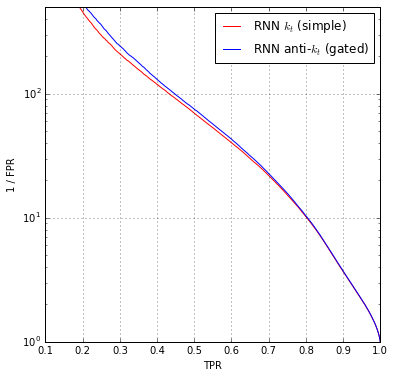

In [46]:
# Simple vs gated
for pattern, gated, label, color in [
        ("antikt-kt", False, "RNN $k_t$ (simple)", "r"),
        ("antikt-kt", True, "RNN anti-$k_t$ (gated)", "b")
    ]:
    
    fd = open("../models/jet-study-2/rocs/rocs-%s-%s.pickle" % ("s" if not gated else "g", pattern), "rb")
    r, f, t = pickle.load(fd)
    fd.close()
    
    plot_rocs(r, f, t, label=label, color=color, show_all=False)
    
plot_show()

/home/gilles/anaconda3/envs/hep/lib/python2.7/site-packages/ipykernel/__main__.py:23: RuntimeWarning: divide by zero encountered in divide


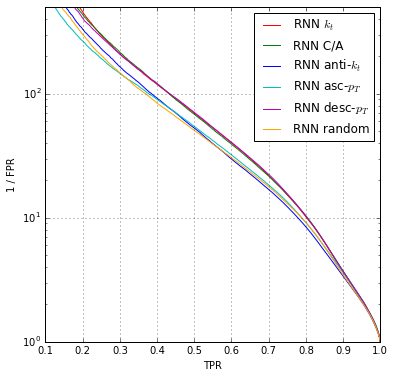

In [47]:
# Topologies (particles, simple)
for pattern, gated, label, color in [
        ("antikt-kt", False, "RNN $k_t$", "r"), 
        ("antikt-cambridge", False, "RNN C/A", "g"),
        ("antikt-antikt", False, "RNN anti-$k_t$", "b"), 
        ("antikt-seqpt", False, "RNN asc-$p_T$", "c"),
        ("antikt-seqpt-reversed", False, "RNN desc-$p_T$", "m"),
        ("antikt-random", False, "RNN random", "orange")
    ]:
    
    fd = open("../models/jet-study-2/rocs/rocs-%s-%s.pickle" % ("s" if not gated else "g", pattern), "rb")
    r, f, t = pickle.load(fd)
    fd.close()
    
    plot_rocs(r, f, t, label=label, color=color, show_all=False)
    
plot_show()

/home/gilles/anaconda3/envs/hep/lib/python2.7/site-packages/ipykernel/__main__.py:23: RuntimeWarning: divide by zero encountered in divide


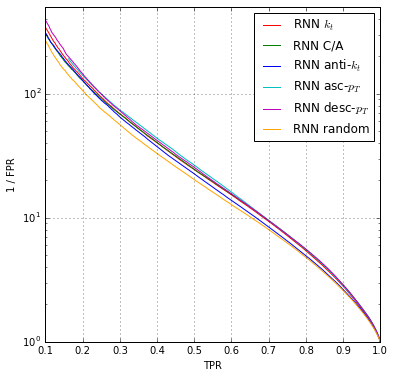

In [48]:
# Topologies (towers, simple)
for pattern, gated, label, color in [
        ("antikt-kt-delphes", False, "RNN $k_t$", "r"), 
        ("antikt-cambridge-delphes", False, "RNN C/A", "g"),
        ("antikt-antikt-delphes", False, "RNN anti-$k_t$", "b"), 
        ("antikt-seqpt-delphes", False, "RNN asc-$p_T$", "c"),
        ("antikt-seqpt-reversed-delphes", False, "RNN desc-$p_T$", "m"),
        ("antikt-random-delphes", False, "RNN random", "orange")
    ]:
    
    fd = open("../models/jet-study-2/rocs/rocs-%s-%s.pickle" % ("s" if not gated else "g", pattern), "rb")
    r, f, t = pickle.load(fd)
    fd.close()
    
    plot_rocs(r, f, t, label=label, color=color, show_all=False)
    
plot_show()

/home/gilles/anaconda3/envs/hep/lib/python2.7/site-packages/ipykernel/__main__.py:23: RuntimeWarning: divide by zero encountered in divide


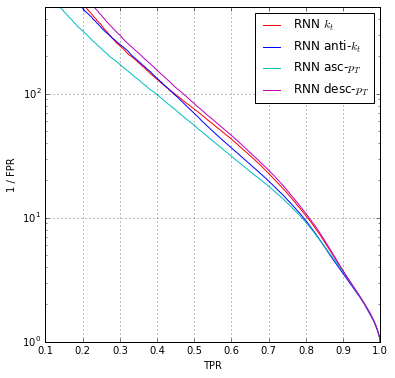

In [49]:
# Topologies (particles, gated)
for pattern, gated, label, color in [
        ("antikt-kt", True, "RNN $k_t$", "r"), 
        ("antikt-antikt", True, "RNN anti-$k_t$", "b"), 
        ("antikt-seqpt", True, "RNN asc-$p_T$", "c"),
        ("antikt-seqpt-reversed", True, "RNN desc-$p_T$", "m"),
    ]:
    
    fd = open("../models/jet-study-2/rocs/rocs-%s-%s.pickle" % ("s" if not gated else "g", pattern), "rb")
    r, f, t = pickle.load(fd)
    fd.close()
    
    plot_rocs(r, f, t, label=label, color=color, show_all=False)
    
plot_show()

/home/gilles/anaconda3/envs/hep/lib/python2.7/site-packages/ipykernel/__main__.py:23: RuntimeWarning: divide by zero encountered in divide


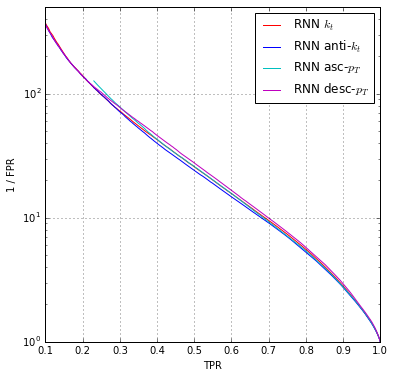

In [50]:
# Topologies (towers, gated)
for pattern, gated, label, color in [
        ("antikt-kt-delphes", True, "RNN $k_t$", "r"), 
        ("antikt-antikt-delphes", True, "RNN anti-$k_t$", "b"), 
        ("antikt-seqpt-delphes", True, "RNN asc-$p_T$", "c"),
        ("antikt-seqpt-reversed-delphes", True, "RNN desc-$p_T$", "m"),
    ]:
    
    fd = open("../models/jet-study-2/rocs/rocs-%s-%s.pickle" % ("s" if not gated else "g", pattern), "rb")
    r, f, t = pickle.load(fd)
    fd.close()
    
    plot_rocs(r, f, t, label=label, color=color, show_all=False)
    
plot_show()

/home/gilles/anaconda3/envs/hep/lib/python2.7/site-packages/ipykernel/__main__.py:23: RuntimeWarning: divide by zero encountered in divide


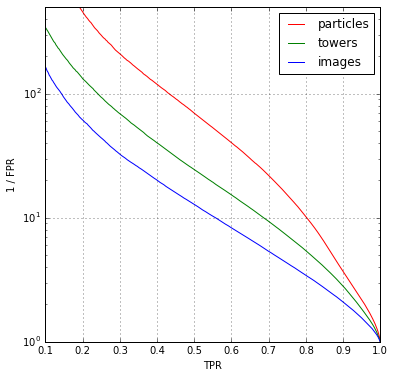

In [51]:
# Particles vs towers vs images (simple)
for pattern, gated, label, color in [
        ("antikt-kt", False, "particles", "r"), 
        ("antikt-kt-delphes", False, "towers", "g"),
        ("antikt-kt-images", False, "images", "b"), 
    ]:
    
    fd = open("../models/jet-study-2/rocs/rocs-%s-%s.pickle" % ("s" if not gated else "g", pattern), "rb")
    r, f, t = pickle.load(fd)
    fd.close()
    
    plot_rocs(r, f, t, label=label, color=color, show_all=False)
    
plot_show()

/home/gilles/anaconda3/envs/hep/lib/python2.7/site-packages/ipykernel/__main__.py:23: RuntimeWarning: divide by zero encountered in divide


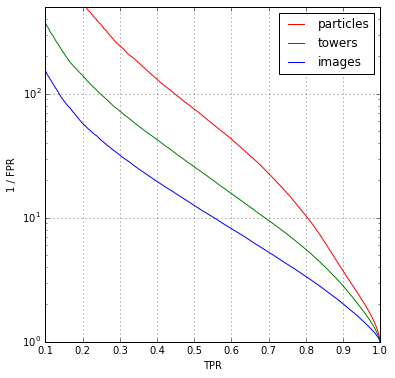

In [52]:
# Particles vs towers vs images (gated)
for pattern, gated, label, color in [
        ("antikt-kt", True, "particles", "r"), 
        ("antikt-kt-delphes", True, "towers", "g"),
        ("antikt-kt-images", True, "images", "b"), 
    ]:
    
    fd = open("../models/jet-study-2/rocs/rocs-%s-%s.pickle" % ("s" if not gated else "g", pattern), "rb")
    r, f, t = pickle.load(fd)
    fd.close()
    
    plot_rocs(r, f, t, label=label, color=color, show_all=False)
    
plot_show()

---

# Trimming

In [ ]:
for prefix1, prefix2, color in [("antikt-kt", "antikt-kt", "r"), 
                                ("antikt-kt", "antikt-kt-trimmed", "orange"),
                                ("antikt-kt-trimmed", "antikt-kt-trimmed", "b"),
                                ("antikt-kt-trimmed", "antikt-kt", "c")]:
    tf = load_tf("../data/w-vs-qcd/final/%s-train.pickle" % prefix1)
    X, y, w = load_test(tf, "../data/w-vs-qcd/final/%s-test.pickle" % prefix2) 
    rocs, fprs, tprs = evaluate_models(X, y, w, "../models/jet-study-2/model-w-s-%s-[0-9]*.pickle" % prefix1)
    plot_rocs(rocs, fprs, tprs, label="%s on %s" % (prefix1, prefix2), color=color)

plot_show()

# Colinear splits

In [ ]:
color = "b"

tf = load_tf("../data/w-vs-qcd/final/antikt-kt-train.pickle")
X, y, w = load_test(tf, "../data/w-vs-qcd/final/antikt-kt-colinear10-test.pickle") 

rocs, fprs, tprs = evaluate_models(X, y, w, "../models/jet-study-2/model-w-s-%s-[0-9]*.pickle" % "antikt-kt")
plot_rocs(rocs, fprs, tprs, label="10 colinear splits", color=color)

plot_show()

In [ ]:
from functools import partial
color = "b"

preprocess = partial(sequentialize_by_pt, reverse=True)
tf = load_tf("../data/w-vs-qcd/final/antikt-kt-train.pickle", preprocess=preprocess)
X, y, w = load_test(tf, "../data/w-vs-qcd/final/antikt-kt-colinear10-test.pickle", preprocess=preprocess) 

rocs, fprs, tprs = evaluate_models(X, y, w, "../models/jet-study-2/model-w-s-%s-[0-9]*.pickle" % "antikt-seqpt-reversed")
plot_rocs(rocs, fprs, tprs, label="10 colinear splits", color=color)

plot_show()

In [ ]:
color = "b"

tf = load_tf("../data/w-vs-qcd/final/antikt-kt-train.pickle")
X, y, w = load_test(tf, "../data/w-vs-qcd/final/antikt-kt-colinear1-max-test.pickle") 

rocs, fprs, tprs = evaluate_models(X, y, w, "../models/jet-study-2/model-w-s-%s-[0-9]*.pickle" % "antikt-kt")
plot_rocs(rocs, fprs, tprs, label="1 colinear splits", color=color)

plot_show()

In [ ]:
from functools import partial
color = "b"

preprocess = partial(sequentialize_by_pt, reverse=True)
tf = load_tf("../data/w-vs-qcd/final/antikt-kt-train.pickle", preprocess=preprocess)
X, y, w = load_test(tf, "../data/w-vs-qcd/final/antikt-kt-colinear1-max-test.pickle", preprocess=preprocess) 

rocs, fprs, tprs = evaluate_models(X, y, w, "../models/jet-study-2/model-w-s-%s-[0-9]*.pickle" % "antikt-seqpt-reversed")
plot_rocs(rocs, fprs, tprs, label="1 colinear splits", color=color)

plot_show()

---

In [ ]:
X, y = load_test(tf, "../data/w-vs-qcd/final/antikt-kt-test.pickle", cropping=False) 
y_pred1 = predict(X[:5000], "../models/jet-study-2/model-w-s-antikt-kt-1.pickle")
X, y = load_test(tf, "../data/w-vs-qcd/final/antikt-kt-colinear1-test.pickle", cropping=False) 
y_pred2 = predict(X[:5000], "../models/jet-study-2/model-w-s-antikt-kt-1.pickle")
X, y = load_test(tf, "../data/w-vs-qcd/final/antikt-kt-colinear10-test.pickle", cropping=False) 
y_pred3 = predict(X[:5000], "../models/jet-study-2/model-w-s-antikt-kt-1.pickle")

In [ ]:
plt.title("original vs 1 colinear split")
plt.scatter(y_pred1, y_pred2, marker=".", alpha=0.1)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.plot(np.linspace(0, 1), np.linspace(0, 1), "r")
plt.show()

In [ ]:
plt.title("original vs 10 colinear splits")
plt.scatter(y_pred1, y_pred3, marker=".", alpha=0.1)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.plot(np.linspace(0, 1), np.linspace(0, 1), "r")
plt.show()

# Soft particles

In [ ]:
# prefix = "antikt-kt"
# color = "r"
# tf = load_tf("../data/w-vs-qcd/final/%s-train.pickle" % prefix)
# X, y, w = load_test(tf, "../data/w-vs-qcd/final/%s-test.pickle" % prefix) 
# rocs, fprs, tprs = evaluate_models(X, y, w, "../models/jet-study-2/model-w-s-%s-[0-9]*.pickle" % prefix)
# plot_rocs(rocs, fprs, tprs, label=prefix, color=color)

tf = load_tf("../data/w-vs-qcd/final/antikt-seqpt-reversed-train.pickle")

color = "b"
X, y, w = load_test(tf, "../data/w-vs-qcd/final/%s-test.pickle" % "antikt-kt-soft") 
rocs, fprs, tprs = evaluate_models(X, y, w, "../models/jet-study-2/model-w-s-%s-[0-9]*.pickle" % prefix)
plot_rocs(rocs, fprs, tprs, label="antikt-kt + soft particles", color=color)

plot_show()

In [ ]:
X, y = load_test(tf, "../data/w-vs-qcd/final/antikt-kt-test.pickle", cropping=False) 
y_pred1 = predict(X[:5000], "../models/jet-study-2/model-w-s-antikt-kt-1.pickle")
X, y = load_test(tf, "../data/w-vs-qcd/final/antikt-kt-soft-test.pickle", cropping=False) 
y_pred2 = predict(X[:5000], "../models/jet-study-2/model-w-s-antikt-kt-1.pickle")

In [ ]:
plt.title("original vs original+soft particles")
plt.scatter(y_pred1, y_pred2, marker=".", alpha=0.1)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.plot(np.linspace(0, 1), np.linspace(0, 1), "r")
plt.show()

In [ ]:
y_ = y[:5000]
_, r, _ = plt.hist(y_pred1[y_ == 0], bins=40, histtype="step", normed=1, color="b", label="original | Y=0")
plt.hist(y_pred2[y_ == 0], bins=r, histtype="step", normed=1, color="c", label="original + soft particles | Y=0")
_, r, _ = plt.hist(y_pred1[y_ == 1], bins=40, histtype="step", normed=1, color="r", label="original | Y=1")
plt.hist(y_pred2[y_ == 1], bins=r, histtype="step", normed=1, color="orange", label="original + soft particles | Y=1")
plt.legend(loc="upper left")
plt.show()